In [225]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re

In [226]:
basePath = "D:\\development\\m3_stuff\\m3_traditional2\\M3\\branches\\M3Hybrid64\\m3\\M3\\data\\ggfx"

In [227]:
filenamePattern = '(left|right)_nominals_([0-9]*)\.txt'
filenamePattern = re.compile(filenamePattern)

nominals = None

with os.scandir(basePath) as entries:
    for entry in entries:
        m = filenamePattern.match(entry.name)
        if m == None or (not entry.is_file()):
            continue
        side = m.group(1)
        toothId = m.group(2)
        #print("Found {} nominal profile for tooth {}: {}".format(m.group(1), m.group(2), entry.path))
        partNominals = pd.read_csv(entry.path,
                                  delimiter=' ', header=None, 
                                   names=['x', 'y', 'z', 'dirx', 'diry', 'dirz']).drop(columns=['z', 'dirz'])
        partNominals['angle'] = np.arctan2(partNominals['y'], partNominals['x']) + 2 * np.pi
        partNominals.loc[partNominals['angle'] >= 2 * np.pi, 'angle'] = partNominals.loc[partNominals['angle'] >= 2 * np.pi, 
                                                                                         'angle'] - 2 * np.pi
        partNominals['distance'] = np.sqrt(partNominals['x'] ** 2 + partNominals['y'] ** 2)
        partNominals['side'] = side
        partNominals['source'] = 'nominal'
        partNominals['tooth_id'] = np.int32(toothId)
        
        if type(nominals) == pd.DataFrame:
            nominals = pd.concat([nominals, partNominals], sort=False)
        else:
            nominals = partNominals
        
nominals.reset_index(drop=True, inplace=True)

In [228]:
nominals.shape[0]

612

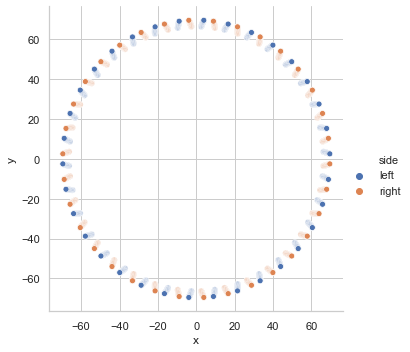

In [229]:
sns.relplot(kind='scatter', x='x', y='y', hue='side', data=nominals)

In [230]:
r = 68.0

In [231]:
precision = 1e-4
pitchNominals = nominals.query('abs(distance - {}) < {}'.format(r, precision)).copy()
pitchNominals['source'] = 'pitch_nominal'
pitchNominals.sort_values(by='angle', inplace=True)

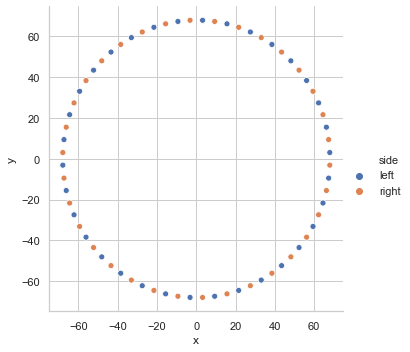

In [232]:
sns.relplot(kind='scatter', x='x', y='y', hue='side', data=pitchNominals)

In [233]:
pitchNominals

,x,y,dirx,diry,angle,distance,side,source,tooth_id
4,67.929578,3.093936,0.298911,0.954281,0.045515,68.000000,left,pitch_nominal,0
319,67.341457,9.440771,0.469170,-0.883108,0.139285,68.000000,right,pitch_nominal,1
13,66.204439,15.523283,0.118473,0.992957,0.230314,68.000000,left,pitch_nominal,1
418,64.460104,21.653985,0.623452,-0.781862,0.324084,68.000001,right,pitch_nominal,2
112,62.224786,27.424003,-0.066000,0.997820,0.415114,68.000000,left,pitch_nominal,2
...,...,...,...,...,...,...,...,...,...
544,62.224786,-27.424003,-0.066000,-0.997820,5.868071,68.000000,right,pitch_nominal,32
238,64.460104,-21.653985,0.623452,0.781862,5.959101,68.000001,left,pitch_nominal,32
553,66.204439,-15.523283,0.118473,-0.992957,6.052871,68.000000,right,pitch_nominal,33
247,67.341457,-9.440771,0.469170,0.883108,6.143901,68.000000,left,pitch_nominal,33


In [234]:
def computeRunout(pitchPoints, nominalBallRadius = None, numCirclePoints = 0):
   
    teethNumber = np.int32(pitchPoints.shape[0] / 2)
    print("teeth: {}".format(teethNumber))
    
    ballRadii = pd.DataFrame.from_dict({ 'tooth_id': np.zeros((teethNumber,), dtype=np.int32),
        'angle': np.zeros((teethNumber,), dtype=np.int32),
        'cx': np.zeros((teethNumber,), dtype=np.int32),
        'cy': np.zeros((teethNumber,), dtype=np.int32),
        'dBallCenter': np.zeros((teethNumber,), dtype=np.int32),
        'radius': np.zeros((teethNumber,), dtype=np.int32),
        'deviation': np.zeros((teethNumber,), dtype=np.int32) })
    print('Structure for result created')
    
    for i in np.arange(0, teethNumber):
        
        print("Processing tooth {}...".format(i))
        # right point and its direction
        a1 = 0
        a2 = 0
        d1 = 0
        d2 = 0
        # left point and its direction
        b1 = 0
        b2 = 0
        s1 = 0
        s2 = 0
        
        if i == 0:
            a1, a2, d1, d2 = pitchPoints.iloc[teethNumber * 2 - 1][['x', 'y', 'dirx', 'diry']]
        else:
            a1, a2, d1, d2 = pitchPoints.iloc[2 * i - 1][['x', 'y', 'dirx', 'diry']]
            
        b1, b2, s1, s2 = pitchPoints.iloc[2 * i][['x', 'y', 'dirx', 'diry']]
        
        centerParValue = (a1 - b1) / (d1 - s1) if np.abs(s1 - d1) > 1e-7 else (a2 - b2) / (d2 - s2)
        ballRadius = np.abs(centerParValue)
        cx = a1 + centerParValue * d1
        cy = a2 + centerParValue * d2
        
        print("Right point: ({}, {}) dir ({}, {})\nLeft point: ({}, {}) dir ({}, {})\nBall radius: {}"
             .format(a1, a2, d1, d2, b1, b2, s1, s2, ballRadius))
        
        ballRadii.loc[i, 'tooth_id'] = pitchPoints.iloc[2 * i]['tooth_id']
        ballRadii.loc[i, 'angle'] = pitchPoints.iloc[2 * i]['angle']
        ballRadii.loc[i, 'cx'] = cx
        ballRadii.loc[i, 'cy'] = cy
        ballRadii.loc[i, 'dBallCenter'] = np.sqrt(cx ** 2 + cy ** 2)
        ballRadii.loc[i, 'radius'] = ballRadius
        if nominalBallRadius:
            ballRadii.loc[i, 'deviation'] = ballRadius - nominalBallRadius
        
    circlePoints = None
    if numCirclePoints > 0:
        circlePoints = pd.DataFrame.from_dict({ 'tooth_id': np.zeros((teethNumber * numCirclePoints,), dtype=np.int32),
                                               'x':  np.zeros((teethNumber * numCirclePoints,), dtype=np.int32),
                                               'y':  np.zeros((teethNumber * numCirclePoints,), dtype=np.int32) })
    
    for i in np.arange(0, teethNumber):
        cx, cy, radius, toothId = ballRadii.loc[i, ['cx', 'cy', 'radius', 'tooth_id']]
        angleStep = 2 * np.pi / numCirclePoints
        for ptId in np.arange(0, numCirclePoints):
            circleAngle = angleStep * ptId
            circlePoints.loc[i * numCirclePoints + ptId, 'tooth_id'] = toothId
            circlePoints.loc[i * numCirclePoints + ptId, 'x'] = cx + radius * np.cos(circleAngle)
            circlePoints.loc[i * numCirclePoints + ptId, 'y'] = cy + radius * np.sin(circleAngle)
        
            
    return (ballRadii, circlePoints)

In [235]:
ballRadii, circlePoints = computeRunout(pitchNominals, numCirclePoints = 16)

teeth: 34
Structure for result created
Processing tooth 0...
Right point: (67.929578, -3.0939360000000002) dir (0.29891100000000004, -0.9542809999999999)
Left point: (67.929578, 3.0939360000000002) dir (0.29891100000000004, 0.9542809999999999)
Ball radius: 3.242164519675023
Processing tooth 1...
Right point: (67.34145699999999, 9.440771) dir (0.46917, -0.883108)
Left point: (66.20443900000001, 15.523283) dir (0.118473, 0.992957)
Ball radius: 3.24216631451077
Processing tooth 2...
Right point: (64.460104, 21.653985000000002) dir (0.623452, -0.781862)
Left point: (62.224786, 27.424003000000003) dir (-0.066, 0.99782)
Ball radius: 3.242166242174944
Processing tooth 3...
Right point: (59.383639, 33.129796999999996) dir (0.7565029999999999, -0.65399)
Left point: (56.126144, 38.390832) dir (-0.248225, 0.9687020000000001)
Ball radius: 3.242166038967767
Processing tooth 4...
Right point: (52.284935, 43.477414) dir (0.863793, -0.503847)
Left point: (48.116193, 48.050307000000004) dir (-0.421997,

In [236]:
nominalBallRadius = ballRadii['radius'].mean()
nominalDistanceToBall = ballRadii['dBallCenter'].mean()

In [237]:
nominalBallRadius

3.242165160858795

In [238]:
nominalDistanceToBall

69.17600836995632

In [239]:
ballRadii

,tooth_id,angle,cx,cy,dBallCenter,radius,deviation
0,0,0.045515,68.898697,-6.187872,69.176009,3.242165,0
1,1,0.230314,68.862584,6.577588,69.176009,3.242166,0
2,2,0.415114,66.481439,19.119058,69.176008,3.242166,0
3,3,0.599913,61.836347,31.009453,69.176008,3.242166,0
4,4,0.784713,55.085494,41.843859,69.176009,3.242164,0
5,5,0.969513,46.458769,51.253320,69.176008,3.242164,0
6,6,1.154312,36.249947,58.917411,69.176007,3.242166,0
7,7,1.339112,24.806677,64.575142,69.176009,3.242164,0
8,8,1.523911,12.518646,68.033842,69.176009,3.242165,0
9,9,1.708711,-0.195694,69.175733,69.176010,3.242165,0


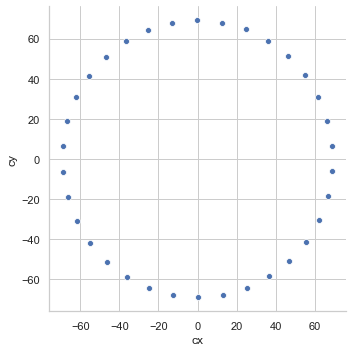

In [240]:
sns.relplot(kind='scatter', x='cx', y='cy', data=ballRadii, height=5, aspect=1)

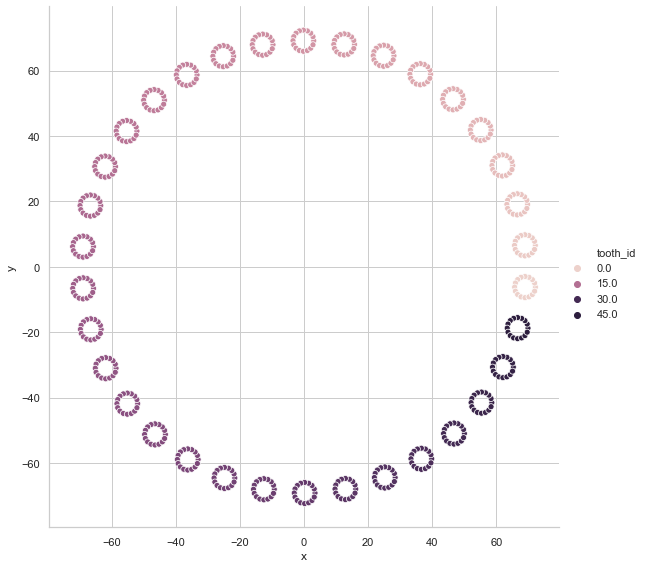

In [241]:
sns.relplot(kind='scatter', x = 'x', y = 'y', data=circlePoints, hue='tooth_id', height=8, aspect=1)

In [242]:
def makePitchAndCircleData(pitches, circles):
    queryPitches = pitches[['tooth_id', 'x', 'y']].copy()
    queryPitches['source'] = 'pitch'
    queryCircles = circles[['tooth_id', 'x', 'y']].copy()
    queryCircles['source'] = 'circle'
    #return pd.concat((pitches[['tooth_id', 'x', 'y']], circles[['tooth_id', 'x', 'y']]), sort=False).reset_index(drop=True)
    return pd.concat((queryPitches, queryCircles), sort=False).reset_index(drop=True)

In [243]:
pitchAndCircles = makePitchAndCircleData(pitchNominals, circlePoints)

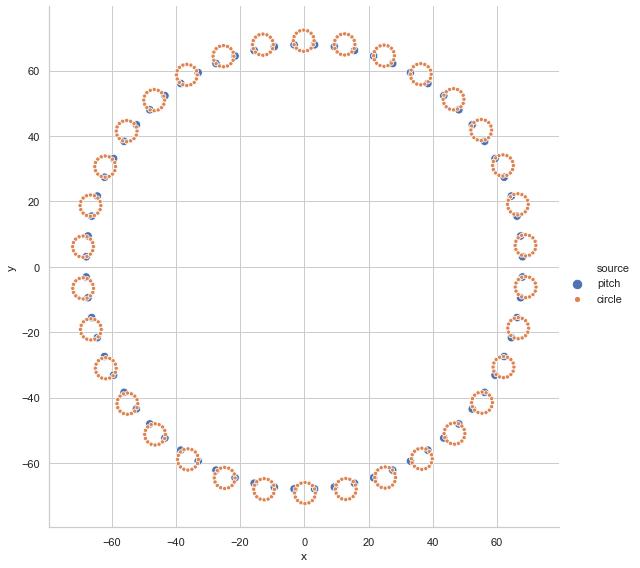

In [244]:
sns.relplot(kind='scatter', x = 'x', y = 'y', data=pitchAndCircles, size='source', hue='source', height=8, aspect=1)

In [245]:
actualPitchLeft = pd.read_csv(os.path.join(basePath, "actual_pitch_left.txt"),
                             delimiter=',', header=None, names=['tooth_id', 'x', 'y'])
actualPitchLeft['side'] = 'left'
actualPitchRight = pd.read_csv(os.path.join(basePath, "actual_pitch_right.txt"),
                             delimiter=',', header=None, names=['tooth_id', 'x', 'y'])
actualPitchRight['side'] = 'right'
actualPitch = pd.concat((actualPitchLeft, actualPitchRight), sort=False)
actualPitch['angle'] = np.arctan2(actualPitch['y'], actualPitch['x']) + 2 * np.pi
actualPitch.loc[actualPitch['angle'] >= 2 * np.pi, 'angle'] = actualPitch.loc[actualPitch['angle'] >= 2 * np.pi, 
                                                                              'angle'] - 2 * np.pi
actualPitch['distance'] = np.sqrt(actualPitch['x'] ** 2 + actualPitch['y'] ** 2)
actualPitch['source'] = 'pitch_actual'
actualPitch.reset_index(drop=True, inplace=True)
actualPitch.sort_values(by='angle', inplace=True)

In [246]:
actualPitch.shape[0]

68

In [247]:
pitchNominals.shape[0]

68

In [248]:
#actualPitch['dirx'] = pitchNominals['dirx']
#actualPitch['diry'] = pitchNominals['diry']

In [249]:
actualPitch = actualPitch.merge(pitchNominals, on=['tooth_id', 'side'], suffixes=('', '_right'))

In [250]:
ballRadii, circlePoints = computeRunout(actualPitch, nominalBallRadius=nominalBallRadius, numCirclePoints=16)

teeth: 34
Structure for result created
Processing tooth 0...
Right point: (67.9291, -3.1034) dir (0.29891100000000004, -0.9542809999999999)
Left point: (67.9271, 3.1490099999999996) dir (0.29891100000000004, 0.9542809999999999)
Ball radius: 3.2759795070843913
Processing tooth 1...
Right point: (67.3428, 9.43084) dir (0.46917, -0.883108)
Left point: (66.1918, 15.5774) dir (0.118473, 0.992957)
Ball radius: 3.2820354893255326
Processing tooth 2...
Right point: (64.464, 21.6423) dir (0.623452, -0.781862)
Left point: (62.2026, 27.4744) dir (-0.066, 0.99782)
Ball radius: 3.2799962869061257
Processing tooth 3...
Right point: (59.3891, 33.12) dir (0.7565029999999999, -0.65399)
Left point: (56.0947, 38.4369) dir (-0.248225, 0.9687020000000001)
Ball radius: 3.278897373219415
Processing tooth 4...
Right point: (52.2917, 43.4693) dir (0.863793, -0.503847)
Left point: (48.0767, 48.0898) dir (-0.421997, 0.906597)
Ball radius: 3.27814028729419
Processing tooth 5...
Right point: (43.4148, 52.336999999

In [251]:
ballRadii

,tooth_id,angle,cx,cy,dBallCenter,radius,deviation
0,0,0.046326,68.908326,-6.229605,69.189345,3.275980,0.033814
1,1,0.231132,68.882633,6.532448,69.191690,3.282035,0.039870
2,2,0.415924,66.508920,19.077796,69.191031,3.279996,0.037831
3,3,0.600734,61.869596,30.975634,69.190583,3.278897,0.036732
4,4,0.785534,55.123335,41.817619,69.190283,3.278140,0.035975
5,5,0.970362,46.502876,51.233337,69.190840,3.279372,0.037207
6,6,1.155179,36.292965,58.907557,69.190170,3.278130,0.035965
7,7,1.339962,24.848235,64.573737,69.189611,3.276672,0.034507
8,8,1.524779,12.559954,68.040110,69.189660,3.276986,0.034821
9,9,1.709582,-0.158392,69.189171,69.189352,3.276165,0.034000


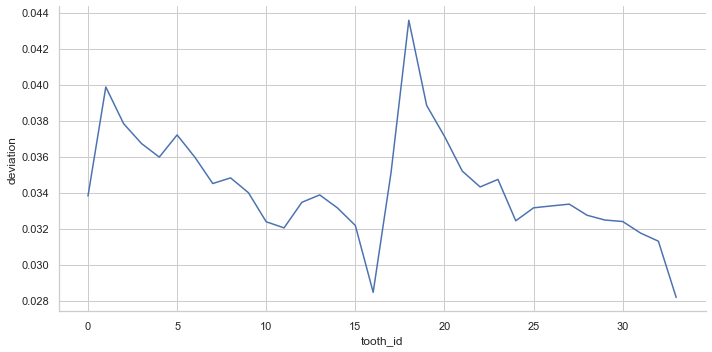

In [252]:
sns.relplot(kind='line', x='tooth_id', y='deviation', data=ballRadii, height=5, aspect=2)

In [253]:
runout = ballRadii['radius'].max() - ballRadii['radius'].min()

In [254]:
runout

0.01539790759547044

In [255]:
pitchAndCircles = makePitchAndCircleData(actualPitch, circlePoints)

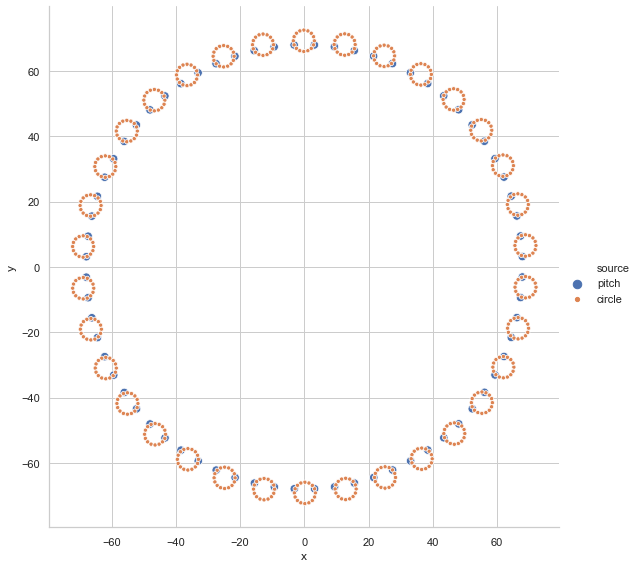

In [256]:
sns.relplot(kind='scatter', x = 'x', y = 'y', data=pitchAndCircles, size='source', hue='source', height=8, aspect=1)

In [257]:
ballRadii['radius'].mean()

3.276467006910676

In [258]:
ballRadii['radius'].std()

0.0030100491560991027

In [259]:
ballRadii['dBallCenter'].mean()

69.18944369783262

In [260]:
ballRadii['dBallCenter'].std()

0.0011819787848201086

In [261]:
nominalDistanceToBall

69.17600836995632

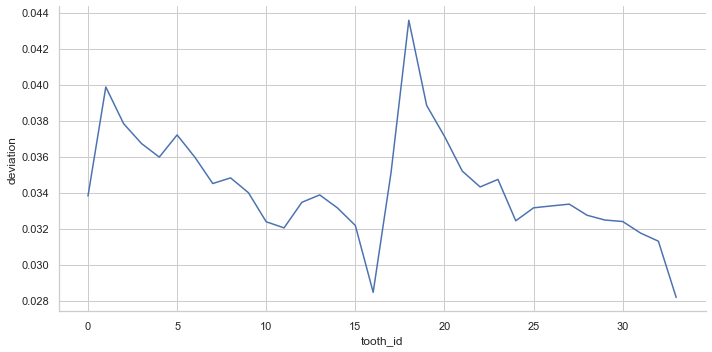

In [262]:
sns.relplot(kind='line', x='tooth_id', y='deviation', data=ballRadii, height=5, aspect=2)

In [263]:
ballRadii['dBallCenter'].max() - ballRadii['dBallCenter'].min()

0.005946984838473668

In [264]:
actualPitch['distance'].mean()

68.00001699543189